In [35]:
%pip install numpy
%pip install keras
%pip install matplotlib
%pip install tensorflow
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
   ---------------------------------------- 294.9/294.9 kB 4.6 MB/s eta 0:00:00



In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import copy

In [28]:
df = pd.read_csv("./wildfire_dataset.csv")

g_causes = {}
a_causes = {}
t_causes = {}

for index in df.index:
    general = df.loc[index, 'general_cause_desc']
    activity = df.loc[index, 'activity_class']
    true_c = df.loc[index, 'true_cause']

    if (general not in g_causes):
        g_causes[general] = [0, {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0}]
    if (activity not in a_causes):
        a_causes[activity] = [0, {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0}]
    if (true_c not in t_causes):
        t_causes[true_c] = [0, {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0}]

FSA_dict = {'C': [0, {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0}], 
            'E': [0, {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0}], 
            'H': [0, {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0}], 
            'G': [0, {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0}], 
            'L': [0, {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0}], 
            'M': [0, {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0}], 
            'P': [0, {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0}], 
            'R': [0, {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0}], 
            'S': [0, {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0}], 
            'W': [0, {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0}]}

causes_dict =  {'C': {'general_c': 0, 'activity_c': 0, 'true_c': 0}, 
                'E': {'general_c': 0, 'activity_c': 0, 'true_c': 0}, 
                'H': {'general_c': 0, 'activity_c': 0, 'true_c': 0}, 
                'G': {'general_c': 0, 'activity_c': 0, 'true_c': 0}, 
                'L': {'general_c': 0, 'activity_c': 0, 'true_c': 0}, 
                'M': {'general_c': 0, 'activity_c': 0, 'true_c': 0}, 
                'P': {'general_c': 0, 'activity_c': 0, 'true_c': 0}, 
                'R': {'general_c': 0, 'activity_c': 0, 'true_c': 0}, 
                'S': {'general_c': 0, 'activity_c': 0, 'true_c': 0}, 
                'W': {'general_c': 0, 'activity_c': 0, 'true_c': 0}}

print(causes_dict)

for key, value in causes_dict.items():
    causes_dict[key]['general_c'] = copy.deepcopy(g_causes)
    causes_dict[key]['activity_c'] = copy.deepcopy(a_causes)
    causes_dict[key]['true_c'] = copy.deepcopy(t_causes)


for index in df.index: 

    region = df.loc[index, 'fire_number']
    region = region[:1]
    FSA_dict[region][0] +=1
    classtemp = df.loc[index, 'size_class']
    FSA_dict[region][1][classtemp] += 1

    general = df.loc[index, 'general_cause_desc']
    causes_dict[region]['general_c'][general][0] += 1
    causes_dict[region]['general_c'][general][1][classtemp] += 1
    activity = df.loc[index, 'activity_class']
    causes_dict[region]['activity_c'][activity][0] += 1
    causes_dict[region]['activity_c'][activity][1][classtemp] += 1
    true_c = df.loc[index, 'true_cause']
    causes_dict[region]['true_c'][true_c][0] += 1
    causes_dict[region]['true_c'][true_c][1][classtemp] += 1

g_causes_total = {}
for key,value in causes_dict.items():
    temp = {}
    for k,v in value['general_c'].items():
        try:
            temp[k] = v[0]
        except(KeyError):
            break
    g_causes_total[key] = temp

print(causes_dict['C'])
print(causes_dict['E'])


{'C': {'general_c': 0, 'activity_c': 0, 'true_c': 0}, 'E': {'general_c': 0, 'activity_c': 0, 'true_c': 0}, 'H': {'general_c': 0, 'activity_c': 0, 'true_c': 0}, 'G': {'general_c': 0, 'activity_c': 0, 'true_c': 0}, 'L': {'general_c': 0, 'activity_c': 0, 'true_c': 0}, 'M': {'general_c': 0, 'activity_c': 0, 'true_c': 0}, 'P': {'general_c': 0, 'activity_c': 0, 'true_c': 0}, 'R': {'general_c': 0, 'activity_c': 0, 'true_c': 0}, 'S': {'general_c': 0, 'activity_c': 0, 'true_c': 0}, 'W': {'general_c': 0, 'activity_c': 0, 'true_c': 0}}
{'general_c': {'Lightning': [151, {'A': 127, 'B': 23, 'C': 1, 'D': 0, 'E': 0}], 'Forest Industry': [24, {'A': 18, 'B': 5, 'C': 1, 'D': 0, 'E': 0}], 'Incendiary': [124, {'A': 74, 'B': 38, 'C': 11, 'D': 1, 'E': 0}], 'Resident': [351, {'A': 279, 'B': 65, 'C': 7, 'D': 0, 'E': 0}], 'Recreation': [3211, {'A': 3170, 'B': 30, 'C': 10, 'D': 0, 'E': 1}], 'Agriculture Industry': [3, {'A': 3, 'B': 0, 'C': 0, 'D': 0, 'E': 0}], 'Government': [1, {'A': 0, 'B': 1, 'C': 0, 'D': 0, 

In [25]:
df

,fire_year,fire_number,fire_name,current_size,size_class,fire_location_latitude,fire_location_longitude,fire_origin,general_cause_desc,industry_identifier_desc,...,distance_from_water_source,first_bucket_drop_date,bh_fs_date,bh_hectares,uc_fs_date,uc_hectares,to_fs_date,to_hectares,ex_fs_date,ex_hectares
0,2021,HWF053,NaN,5.50,C,59.522139,-119.926971,Provincial Land,Lightning,NaN,...,NaN,NaN,6/28/21 22:26,0.01,7/1/21 13:26,10.00,NaN,NaN,7/1/21 13:44,5.50
1,2021,RWF005,NaN,0.01,A,52.692262,-116.118960,Provincial Land,Forest Industry,NaN,...,NaN,NaN,3/30/21 14:30,0.01,3/30/21 14:30,0.01,3/30/21 14:35,0.01,4/9/21 8:30,0.01
2,2021,LWF014,NaN,0.10,A,55.937050,-110.719950,Indian Reservation,Incendiary,NaN,...,NaN,NaN,4/16/21 16:57,0.10,4/16/21 16:57,0.10,NaN,NaN,4/17/21 14:15,0.10
3,2021,MWF002,NaN,0.01,A,56.425933,-111.160750,Indian Reservation,Resident,NaN,...,NaN,NaN,4/17/21 15:20,0.01,4/17/21 15:20,0.01,NaN,NaN,4/17/21 15:24,0.01
4,2021,EWF014,NaN,7.13,C,53.693450,-116.058633,Private Land,Resident,NaN,...,NaN,NaN,4/1/21 19:10,7.13,4/2/21 11:00,7.13,4/2/21 15:52,7.13,4/12/21 14:30,7.13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22909,2006,CWF231,NaN,0.10,A,51.161883,-114.869317,Indian Reservation,Resident,NaN,...,NaN,NaN,3/11/07 17:35,0.01,3/11/07 17:45,0.01,NaN,NaN,3/11/07 18:00,0.10
22910,2006,CWF232,NaN,0.01,A,51.084150,-115.392633,Provincial Park,Undetermined,NaN,...,NaN,NaN,3/19/07 10:25,0.01,3/19/07 10:25,0.01,NaN,NaN,3/19/07 10:40,0.01
22911,2006,CWF233,NaN,0.70,B,51.333900,-114.997667,Provincial Land,Recreation,NaN,...,NaN,NaN,3/26/07 2:00,0.70,3/26/07 2:00,0.70,NaN,NaN,3/26/07 12:00,0.70
22912,2006,CWF234,NaN,0.01,A,51.071467,-115.316300,Provincial Land,Resident,NaN,...,NaN,NaN,3/28/07 11:00,0.01,3/28/07 11:00,0.01,NaN,NaN,3/28/07 11:30,0.01


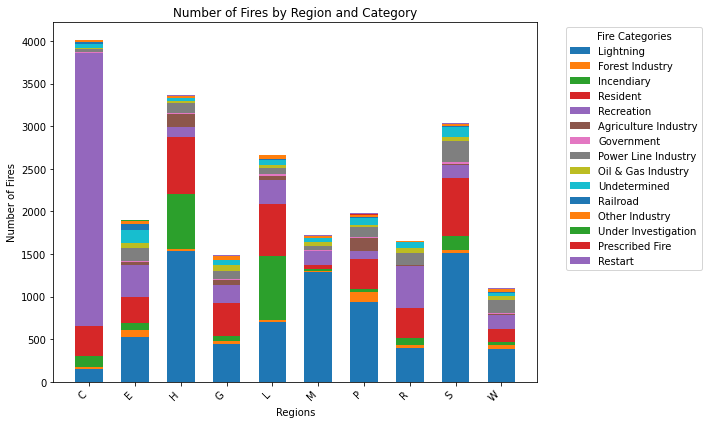

In [29]:
categories = list(g_causes_total['C'].keys())
labels = list(g_causes_total.keys())
num_categories = len(categories)

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.6

for i, category in enumerate(categories):
   
    values = [g_causes_total[label][category] for label in labels]
       
    bottom_values = [sum(g_causes_total[label][categories[j]] for j in range(i)) for label in labels]

    ax.bar(labels, values, width=bar_width, label=category, bottom=bottom_values)

ax.set_ylabel('Number of Fires')
ax.set_xlabel('Regions')  # Flipped: Set x-axis label to 'Regions'
ax.set_title('Number of Fires by Region and Category')
ax.legend(title='Fire Categories', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [44]:
weights = {'A': 0.1, 'B': 4.0, 'C': 20.0, 'D': 200.0, 'E': 1961.53}
weighted_FSA = {'C': 0, 'E': 0, 'H': 0, 'G': 0, 'L': 0, 'M': 0, 'P': 0, 'R': 0, 'S': 0, 'W': 0}

for key, value in FSA_dict.items():
    for k, w in weights.items():
        weighted_FSA[key] += value[1][k]*weights[k]

print(weighted_FSA)    


{'C': 6535.360000000001, 'E': 29056.66, 'H': 257480.41999999998, 'G': 11845.92, 'L': 54439.92999999999, 'M': 193238.13, 'P': 48173.1, 'R': 26269.129999999997, 'S': 102352.62, 'W': 14546.18}


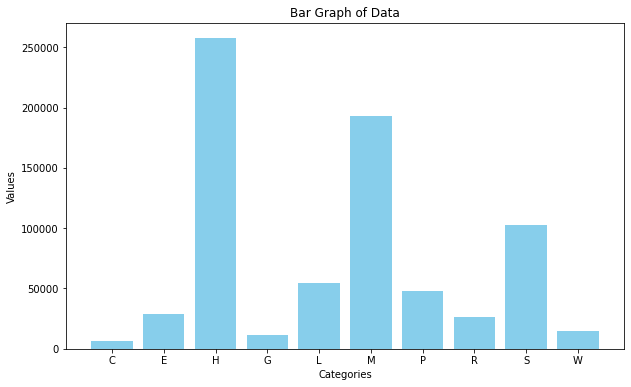

In [45]:
categories = list(weighted_FSA.keys())
values = list(weighted_FSA.values())

# Creating the bar graph
plt.figure(figsize=(10, 6))
plt.bar(categories, values, color='skyblue')
plt.title('Bar Graph of Data')
plt.xlabel('Categories')
plt.ylabel('Values')
plt.show()

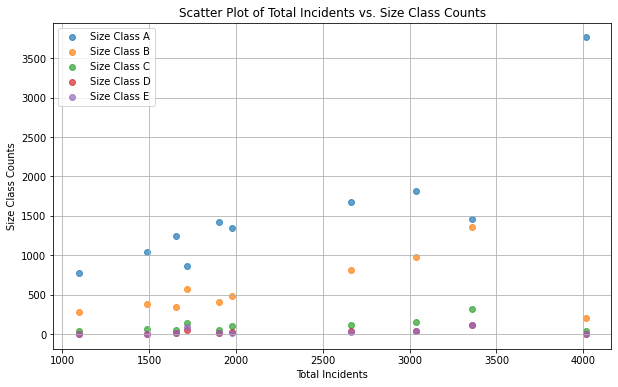

In [52]:
fsa_codes = list(FSA_dict.keys())
total_incidents = [data[0] for data in FSA_dict.values()]
size_class_counts = {cls: [data[1][cls] for data in FSA_dict.values()] for cls in ['A', 'B', 'C', 'D', 'E']}

plt.figure(figsize=(10, 6))
for cls, counts in size_class_counts.items():
    plt.scatter(total_incidents, counts, label=f'Size Class {cls}', alpha=0.7)

plt.title('Scatter Plot of Total Incidents vs. Size Class Counts')
plt.xlabel('Total Incidents')
plt.ylabel('Size Class Counts')
plt.legend()
plt.grid(True)
plt.show()

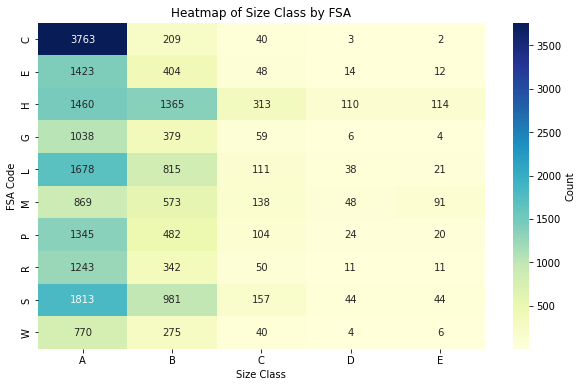

In [49]:
df = pd.DataFrame(FSA_dict).T
df.columns = ['Total', 'Size Class Count']

# Extracting Size Class information
size_class = df.columns

df = df['Size Class Count'].apply(pd.Series)

# Count of Size Classes
count_size_classes = len(df.columns)

plt.figure(figsize=(10, 6))
sns.heatmap(df, annot=True, fmt="d", cmap="YlGnBu", cbar_kws={'label': 'Count'})
plt.title('Heatmap of Size Class by FSA')
plt.xlabel('Size Class')
plt.ylabel('FSA Code')
plt.show()



<Figure size 720x432 with 0 Axes>

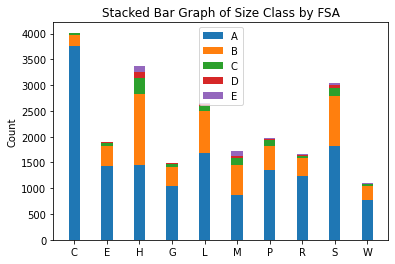

In [51]:
labels = list(FSA_dict.keys())
classes = list(FSA_dict[labels[0]][1].keys())
data = [[FSA_dict[fsa][1][cls] for fsa in labels] for cls in classes]

fig, ax = plt.subplots()
width = 0.35
ind = np.arange(len(labels))
bottom = np.zeros(len(labels))
for i, cls in enumerate(classes):
    ax.bar(ind, data[i], width, bottom=bottom, label=cls)
    bottom += np.array(data[i])

ax.set_ylabel('Count')
ax.set_title('Stacked Bar Graph of Size Class by FSA')
ax.set_xticks(ind)
ax.set_xticklabels(labels)
ax.legend()
plt.show()